# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import os
import shutil


# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')


# Install and Setup PostgreSQL
!apt-get -y -qq install postgresql postgresql-contrib &> /dev/null
!service postgresql start
!sudo -u postgres createuser --superuser adsdb
!sudo -u postgres createdb adsdb
!sudo -u postgres psql -c "ALTER USER adsdb WITH PASSWORD 'adsdb';"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
postgresql: unrecognized service
sudo: unknown user postgres
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user postgres
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user postgres
sudo: error initializing audit plugin sudoers_audit


In [3]:
drive_path = "/content/drive/MyDrive/ADSDB/trusted/dumpfile.sql"
dump_path= "/content/dumpfile.sql"
# Check if the dumpfile exists in the Google Drive
if not os.path.exists(drive_path):
  print("Dump file not found in Google Drive.")


# Copy the dumpfile from Google Drive to Colab's environment
shutil.copy(drive_path, dump_path)
# Create a temporary .pgpass file for authentication
with open("/root/.pgpass", "w") as f:
  f.write("*:*:*:adsdb:adsdb")
os.chmod("/root/.pgpass", 0o600)  # Set the required permissions

# Restore the database using psql command
try:
  !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb < "{dump_path}"
  print("Restoration successful!")
except Exception as e:
  print(f"Error during restoration: {e}")

/bin/bash: line 1: psql: command not found
Restoration successful!


In [5]:
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"

/bin/bash: line 1: psql: command not found


In [6]:
def show_table(table_name):
  display_query = f"SELECT * FROM {table_name} LIMIT 20;"
  !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{display_query}"
def get_table_length(table_name):
  count_query = f"SELECT COUNT(*) FROM {table_name};"
  !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{count_query}"

show_table('final_house_price_index')
get_table_length('final_house_price_index')

/bin/bash: line 1: psql: command not found
/bin/bash: line 1: psql: command not found


# Merge Quarters

In [ ]:
# aggregate data for each year in the tables final_employment_rate and final_house_price_index

# 3 modalities: take the mean, take the last quarter, take the first  'mean','q1','q4'
modality = 'mean'

def merge_quarters(table_name, modality):
  if (modality=='q1'):
    merge_query = f"""
    SELECT *
    FROM {table_name}
    WHERE quarter = 1;
    """
  elif (modality=='q4'):
    merge_query = f"""
    SELECT *
    FROM {table_name}
    WHERE quarter = 4
    """
  else:
    if (table_name == 'final_employment_rate'):
      merge_query = f"""
      SELECT year, sex, provinces, rates, AVG(total) as total
      FROM {table_name}
      GROUP BY year, sex, provinces, rates
      ORDER BY year, sex, provinces, rates;
      """
    elif (table_name == 'final_house_price_index'):
      merge_query = f"""
      SELECT year, indices_and_rates, index_type, autonomous_communities_and_cities, national_total, AVG(total) as total
      FROM {table_name}
      GROUP BY year, indices_and_rates, index_type, autonomous_communities_and_cities, national_total
      ORDER BY year, indices_and_rates, index_type, autonomous_communities_and_cities, national_total;
      """

  # Define the name for the new table
  new_table_name = 'merged_' + table_name

  check_table_query = f"""
      SELECT to_regclass('public.{new_table_name}') IS NOT NULL;
      """
  # Run the query to check if the table exists
  check_result = !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -t -c "{check_table_query}"
  table_exists = check_result[0].strip() == 't'


  # If the table exists, drop the old one
  if table_exists:
     print('dropping table')
     drop_query = f"""
     DROP TABLE {new_table_name};
     """
     !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{drop_query}"

  # Create the new table with the same structure as the query result
  create_table_query = f"""
  CREATE TABLE {new_table_name} AS {merge_query};
  """
  !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{create_table_query}"


modality = 'mean'
merge_quarters('final_employment_rate', modality)
merge_quarters('final_house_price_index', modality)

SELECT 7155
SELECT 3600


In [ ]:
show_table('merged_final_employment_rate')
get_table_length('merged_final_employment_rate')

 year |    sex     |      provinces      |       rates       |        total        
------+------------+---------------------+-------------------+---------------------
 2008 | Both sexes | 01 Araba/Álava      | Activity rate     | 61.6250000000000000
 2008 | Both sexes | 01 Araba/Álava      | Employment rate   | 58.5425000000000000
 2008 | Both sexes | 01 Araba/Álava      | Unemployment rate |  4.9850000000000000
 2008 | Both sexes | 02 Albacete         | Activity rate     | 58.8250000000000000
 2008 | Both sexes | 02 Albacete         | Employment rate   | 51.6475000000000000
 2008 | Both sexes | 02 Albacete         | Unemployment rate | 12.1975000000000000
 2008 | Both sexes | 03 Alicante/Alacant | Activity rate     | 59.0550000000000000
 2008 | Both sexes | 03 Alicante/Alacant | Employment rate   | 51.0775000000000000
 2008 | Both sexes | 03 Alicante/Alacant | Unemployment rate | 13.4875000000000000
 2008 | Both sexes | 04 Almería          | Activity rate     | 61.7350000000000000
 2

In [ ]:
# MERGE PROVINCES INTO COMMUNITIES IN employment_rate
provinces_to_communities = {
    '01 Andalucía': ['02 Albacete', '03 Alicante/Alacant', '04 Almería', '11 Cádiz', '14 Córdoba', '18 Granada', '23 Jaén', '29 Málaga', '41 Sevilla'],
    '02 Aragón': ['50 Zaragoza', '44 Teruel', '22 Huesca'],
    '03 Asturias. Principado de': ['33 Asturias'],
    '04 Balears. Illes': ['07 Balears. Illes'],
    '05 Canarias': ['38 Santa Cruz de Tenerife', '35 Palmas. Las'],
    '06 Cantabria': ['39 Cantabria'],
    '07 Castilla y León': ['05 Ávila', '09 Burgos', '24 León', '34 Palencia', '37 Salamanca', '40 Segovia', '42 Soria', '47 Valladolid', '49 Zamora'],
    '08 Castilla - La Mancha': ['02 Albacete', '13 Ciudad Real', '16 Cuenca', '19 Guadalajara', '45 Toledo'],
    '09 Cataluña': ['08 Barcelona', '17 Girona', '25 Lleida', '43 Tarragona'],
    '10 Comunitat Valenciana': ['03 Alicante/Alacant', '12 Castellón/Castelló', '46 Valencia/València'],
    '11 Extremadura': ['06 Badajoz', '10 Cáceres'],
    '12 Galicia': ['15 Coruña. A', '27 Lugo', '32 Ourense', '36 Pontevedra'],
    '13 Madrid. Comunidad de': ['28 Madrid'],
    '14 Murcia. Región de': ['30 Murcia'],
    '15 Navarra. Comunidad Foral de': ['31 Navarra'],
    '16 País Vasco': ['48 Bizkaia', '20 Gipuzkoa'],
    '17 Rioja. La': ['26 Rioja. La'],
    '18 Ceuta': ['51 Ceuta'],
    '19 Melilla': ['52 Melilla'],
    'NaN': ['National Total'],
}

def merge_provinces(table_name):
    for community, provinces in provinces_to_communities.items():
        for province in provinces:
            # Create SQL UPDATE query to update 'provinces' to 'community' where 'provinces' is 'province'
            merge_query = f"UPDATE {table_name} SET provinces = '{community}' WHERE provinces = '{province}'"
            !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{merge_query}"

    merge_query = f"""
      SELECT year, sex, provinces as communities, rates, AVG(total) as total
      FROM {table_name}
      GROUP BY year, sex, communities, rates
      ORDER BY year, sex, communities, rates;
      """
    new_table_name = 'merged_final_employment_rate2'
    create_table_query = f"""
    CREATE TABLE {new_table_name} AS {merge_query};
    """
    !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{create_table_query}"

merge_provinces('merged_final_employment_rate')
get_table_length('merged_final_employment_rate')
get_table_length('merged_final_employment_rate2')
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"


UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 0
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 0
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
UPDATE 135
SELECT 2970
 count 
-------
  7155
(1 row)

 count 
-------
  2970
(1 row)

           table_name            
---------------------------------
 final_employment_rate
 final_house_price_index
 final_house_price_index_weights
 final_inflation_rate
 merged_final_employment_rate
 merged_final_house_price_index
 merged_final_employment_rate2
(7 rows)



In [ ]:
#omogenize table names
drop_query = f"""
     DROP TABLE IF EXISTS final_employment_rate, final_house_price_index, merged_final_employment_rate;
     """
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{drop_query}"

change_query = f"""
     ALTER TABLE merged_final_house_price_index RENAME TO final_house_price_index;
     """
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{change_query}"

change_query = f"""
     ALTER TABLE merged_final_employment_rate2 RENAME TO final_employment_rate;
     """
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{change_query}"

DROP TABLE
ALTER TABLE
ALTER TABLE


# Drop Columns

In [ ]:
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"

           table_name            
---------------------------------
 final_house_price_index_weights
 final_inflation_rate
 final_house_price_index
 final_employment_rate
(4 rows)



In [ ]:
import subprocess

def execute_sql_command(sql_command):
  query = f"{sql_command}"
  print(query)
  !PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "{query}"

# Example usage:
sql_command = "SELECT * FROM final_employment_rate LIMIT 20;"
execute_sql_command(sql_command)

SELECT * FROM final_employment_rate LIMIT 20;
 year |    sex     |        communities         |       rates       |        total        
------+------------+----------------------------+-------------------+---------------------
 2008 | Both sexes | 01 Andalucía               | Activity rate     | 57.6338888888888889
 2008 | Both sexes | 01 Andalucía               | Employment rate   | 47.9861111111111111
 2008 | Both sexes | 01 Andalucía               | Unemployment rate | 16.7311111111111111
 2008 | Both sexes | 01 Araba/Álava             | Activity rate     | 61.6250000000000000
 2008 | Both sexes | 01 Araba/Álava             | Employment rate   | 58.5425000000000000
 2008 | Both sexes | 01 Araba/Álava             | Unemployment rate |  4.9850000000000000
 2008 | Both sexes | 02 Aragón                  | Activity rate     | 58.6558333333333333
 2008 | Both sexes | 02 Aragón                  | Employment rate   | 54.8116666666666667
 2008 | Both sexes | 02 Aragón                  | Un

In [ ]:
# EMPLOYMENT_RATE
# DROP RWOS WITH BOTH SEX

execute_sql_command("DELETE FROM final_employment_rate WHERE sex = 'Both sexes';")
execute_sql_command("SELECT * FROM final_employment_rate LIMIT 20;")
get_table_length("final_employment_rate")

DELETE FROM final_employment_rate WHERE sex = 'Both sexes';
DELETE 990
SELECT * FROM final_employment_rate LIMIT 20;
 year |   sex   |        communities         |       rates       |        total        
------+---------+----------------------------+-------------------+---------------------
 2008 | Females | 01 Andalucía               | Activity rate     | 47.4036111111111111
 2008 | Females | 01 Andalucía               | Employment rate   | 37.8836111111111111
 2008 | Females | 01 Andalucía               | Unemployment rate | 20.2013888888888889
 2008 | Females | 01 Araba/Álava             | Activity rate     | 52.8300000000000000
 2008 | Females | 01 Araba/Álava             | Employment rate   | 49.8325000000000000
 2008 | Females | 01 Araba/Álava             | Unemployment rate |  5.6725000000000000
 2008 | Females | 02 Aragón                  | Activity rate     | 49.4391666666666667
 2008 | Females | 02 Aragón                  | Employment rate   | 45.5916666666666667
 2008 | Fem

In [ ]:
# HOUSE_PRICE_INDEX
# Drop indices_and_rates different from 'Index' (annual and quarter variation)
execute_sql_command("DELETE FROM final_house_price_index WHERE indices_and_rates <> 'Index';")
# Drop column nationaò_total
execute_sql_command("ALTER TABLE final_house_price_index DROP COLUMN national_total;")
# NaN values in autonomous communities and cities become 'National'
execute_sql_command("UPDATE final_house_price_index SET autonomous_communities_and_cities = 'National' WHERE autonomous_communities_and_cities = 'NaN';")

execute_sql_command("SELECT * FROM final_house_price_index LIMIT 20;")
get_table_length("final_house_price_index")

DELETE FROM final_house_price_index WHERE indices_and_rates <> 'Index';
DELETE 2700
ALTER TABLE final_house_price_index DROP COLUMN national_total;
ALTER TABLE
UPDATE final_house_price_index SET autonomous_communities_and_cities = 'National' WHERE autonomous_communities_and_cities = 'NaN';
UPDATE 45
SELECT * FROM final_house_price_index LIMIT 20;
 year | indices_and_rates |  index_type  | autonomous_communities_and_cities |        total         
------+-------------------+--------------+-----------------------------------+----------------------
 2008 | Index             | General      | 01 Andalucía                      | 134.5350000000000000
 2008 | Index             | General      | 02 Aragón                         | 171.5500000000000000
 2008 | Index             | General      | 03 Asturias. Principado de        | 145.6475000000000000
 2008 | Index             | General      | 04 Balears. Illes                 | 137.5250000000000000
 2008 | Index             | General      | 05 Can

In [ ]:
# HOUSE PRICE INDEX WEIGHTS


# Join

In [ ]:
# JOIN of inflation_rate x house_price_index
execute_sql_command("""CREATE TABLE JoinedTable AS
SELECT final_inflation_rate.*, price.indices_and_rates, price.index_type, price.autonomous_communities_and_cities, price.total
FROM final_inflation_rate
INNER JOIN final_house_price_index price ON final_inflation_rate.year = price.year;
""")
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"


CREATE TABLE JoinedTable AS
SELECT final_inflation_rate.*, price.indices_and_rates, price.index_type, price.autonomous_communities_and_cities, price.total
FROM final_inflation_rate
INNER JOIN final_house_price_index price ON final_inflation_rate.year = price.year;

SELECT 900
           table_name            
---------------------------------
 final_house_price_index_weights
 final_inflation_rate
 final_house_price_index
 final_employment_rate
 joinedtable
(5 rows)



In [ ]:
show_table('joinedtable')
get_table_length('joinedtable')

 year | inflation_rate_percent | annual_change | indices_and_rates |      index_type      | autonomous_communities_and_cities |        total         
------+------------------------+---------------+-------------------+----------------------+-----------------------------------+----------------------
 2008 |                   4.08 |          1.29 | Index             | Second-hand dwelling | National                          | 156.4575000000000000
 2008 |                   4.08 |          1.29 | Index             | New dwelling         | National                          | 136.1325000000000000
 2008 |                   4.08 |          1.29 | Index             | Second-hand dwelling | 19 Melilla                        |                  NaN
 2008 |                   4.08 |          1.29 | Index             | Second-hand dwelling | 18 Ceuta                          |                  NaN
 2008 |                   4.08 |          1.29 | Index             | Second-hand dwelling | 17 Rioja. La

In [ ]:
# JOIN x employment_rate
show_table('final_employment_rate')

 year |   sex   |        communities         |       rates       |        total        
------+---------+----------------------------+-------------------+---------------------
 2008 | Females | 01 Andalucía               | Activity rate     | 47.4036111111111111
 2008 | Females | 01 Andalucía               | Employment rate   | 37.8836111111111111
 2008 | Females | 01 Andalucía               | Unemployment rate | 20.2013888888888889
 2008 | Females | 01 Araba/Álava             | Activity rate     | 52.8300000000000000
 2008 | Females | 01 Araba/Álava             | Employment rate   | 49.8325000000000000
 2008 | Females | 01 Araba/Álava             | Unemployment rate |  5.6725000000000000
 2008 | Females | 02 Aragón                  | Activity rate     | 49.4391666666666667
 2008 | Females | 02 Aragón                  | Employment rate   | 45.5916666666666667
 2008 | Females | 02 Aragón                  | Unemployment rate |  7.7708333333333333
 2008 | Females | 03 Asturias. Principado

In [ ]:
!PGPASSFILE=/root/.pgpass psql -h localhost -U adsdb -d adsdb -c "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"

           table_name            
---------------------------------
 final_house_price_index_weights
 final_inflation_rate
 final_house_price_index
 final_employment_rate
 joinedtable
(5 rows)



In [ ]:
execute_sql_command("""CREATE TABLE JoinedTableFinal AS
SELECT joinedtable.*, e.sex, e.rates, e.total as employment_total
FROM joinedtable
INNER JOIN final_employment_rate e ON joinedtable.year = e.year AND joinedtable.autonomous_communities_and_cities = e.communities;
""")
show_table('JoinedTableFinal')
get_table_length('JoinedTableFinal')

CREATE TABLE JoinedTableFinal AS
SELECT joinedtable.*, e.sex, e.rates, e.total as employment_total
FROM joinedtable
INNER JOIN final_employment_rate e ON joinedtable.year = e.year AND joinedtable.autonomous_communities_and_cities = e.communities;

SELECT 5130
 year | inflation_rate_percent | annual_change | indices_and_rates |      index_type      | autonomous_communities_and_cities |        total         |   sex   |       rates       |  employment_total   
------+------------------------+---------------+-------------------+----------------------+-----------------------------------+----------------------+---------+-------------------+---------------------
 2008 |                   4.08 |          1.29 | Index             | General              | 01 Andalucía                      | 134.5350000000000000 | Females | Activity rate     | 47.4036111111111111
 2008 |                   4.08 |          1.29 | Index             | New dwelling         | 01 Andalucía                      | 121.102

In [ ]:
csv_path = '/content/drive/MyDrive/ADSDB/exploitation/joined_table.csv'
df.to_csv(csv_path, index=False)


# Data Analysis

In [ ]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Define PostgreSQL connection parameters
db_params = {
    'dbname': 'adsdb',
    'user': 'adsdb',
    'password': 'adsdb',
    'host': 'localhost',
    'port': '5432'
}

# Connect to the PostgreSQL database
conn = psycopg2.connect(**db_params)

# Read the 'JoinedTableFinal' into a DataFrame
df = pd.read_sql('SELECT * FROM JoinedTableFinal', conn)

# Close the database connection
conn.close()

df.head()


<ipython-input-20-d4fa753b54c7>:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM JoinedTableFinal', conn)


,year,inflation_rate_percent,annual_change,indices_and_rates,index_type,autonomous_communities_and_cities,total,sex,rates,employment_total
0,2008,4.08,1.29,Index,General,01 Andalucía,134.5350,Females,Activity rate,47.403611
1,2008,4.08,1.29,Index,New dwelling,01 Andalucía,121.1025,Females,Activity rate,47.403611
2,2008,4.08,1.29,Index,Second-hand dwelling,01 Andalucía,145.0575,Females,Activity rate,47.403611
3,2008,4.08,1.29,Index,General,01 Andalucía,134.5350,Females,Employment rate,37.883611
4,2008,4.08,1.29,Index,New dwelling,01 Andalucía,121.1025,Females,Employment rate,37.883611


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               5130 non-null   int64  
 1   inflation_rate_percent             5130 non-null   float64
 2   annual_change                      5130 non-null   float64
 3   indices_and_rates                  5130 non-null   object 
 4   index_type                         5130 non-null   object 
 5   autonomous_communities_and_cities  5130 non-null   object 
 6   total                              4770 non-null   float64
 7   sex                                5130 non-null   object 
 8   rates                              5130 non-null   object 
 9   employment_total                   5130 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 400.9+ KB


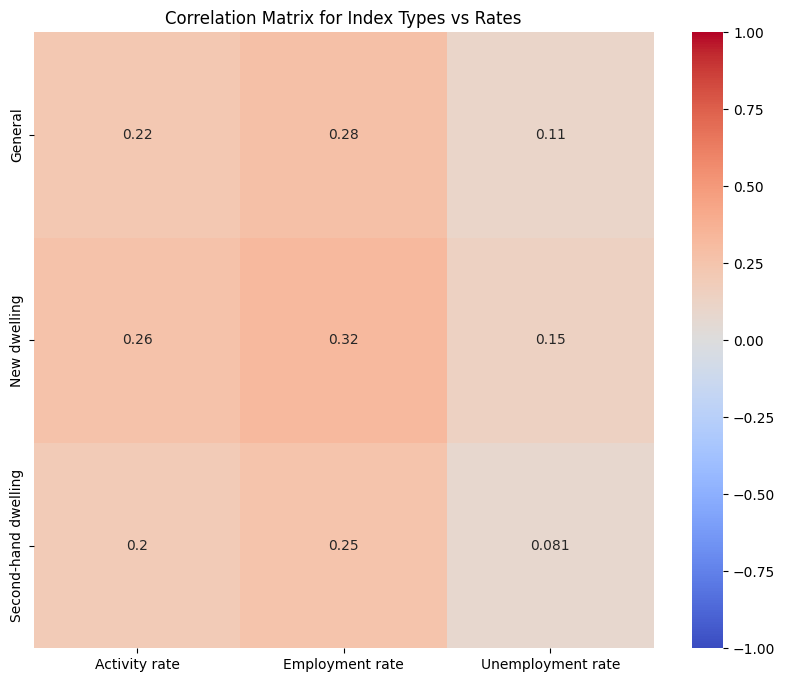

In [ ]:
# Get unique values
index_types = df['index_type'].unique()
rates_types = df['rates'].unique()

# Create an empty DataFrame for storing correlations
correlation_matrix = pd.DataFrame(index=index_types, columns=rates_types)

# Fill the DataFrame with correlations
for i_type in index_types:
    for r_type in rates_types:
        subset_df = df[(df['index_type'] == i_type) & (df['rates'] == r_type)]
        corr_total = subset_df['total'].corr(subset_df['inflation_rate_percent'])
        corr_employment = subset_df['employment_total'].corr(subset_df['inflation_rate_percent'])
        # Storing average of the two correlations for simplicity
        correlation_matrix.loc[i_type, r_type] = np.mean([corr_total, corr_employment])

# Convert to float for visualization
correlation_matrix = correlation_matrix.astype(float)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Index Types vs Rates')
plt.show()


## Linear regression

Rows with outliers in 'inflation_rate_percent': 2022 



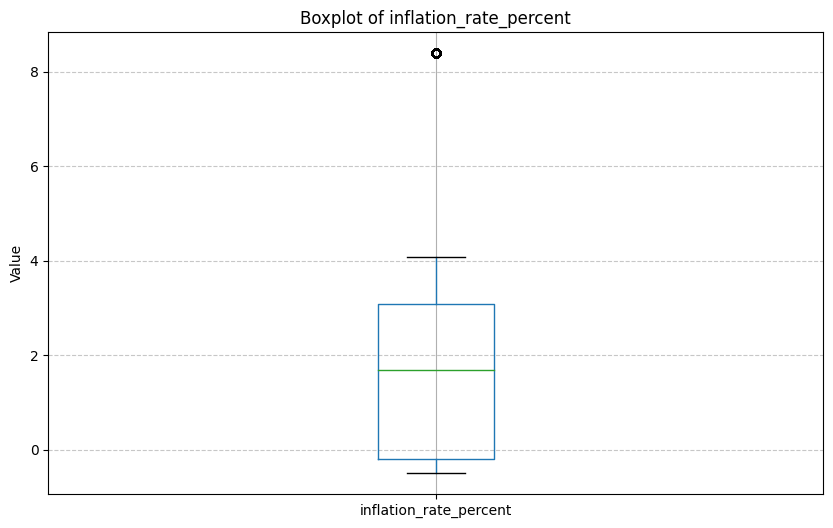

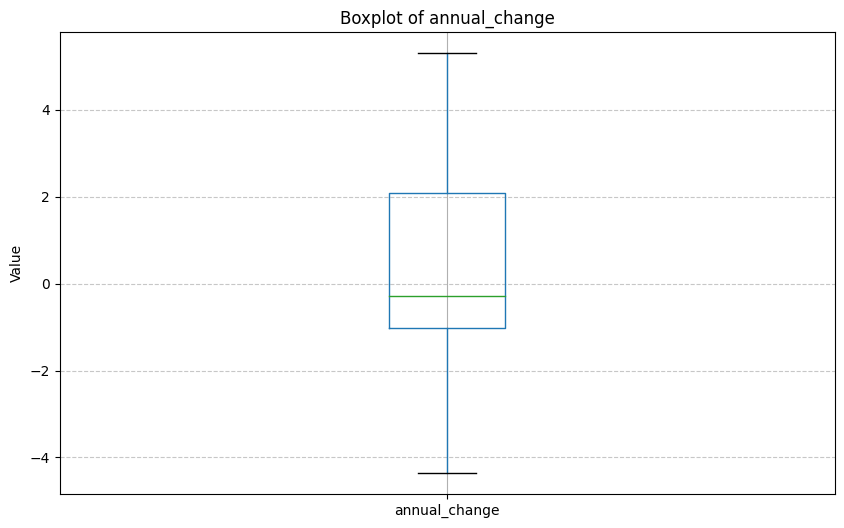

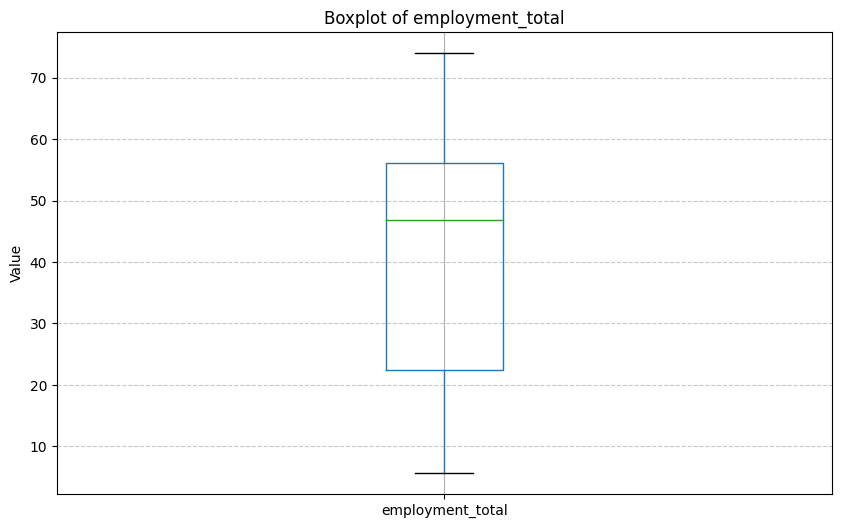

In [ ]:
columns_to_plot = ['inflation_rate_percent', 'annual_change', 'employment_total']

def show_outliers(df, columns_to_plot):
    for col in columns_to_plot:
        # Create a separate boxplot for each column
        plt.figure(figsize=(10, 6))
        boxplot = df.boxplot(column=col)
        plt.title(f'Boxplot of {col}')
        plt.ylabel('Value')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Identify and output rows with outliers for the current column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find rows with outliers
        outlier_rows = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Print rows with outliers for the current column
        if not outlier_rows.empty:
            elements = list(outlier_rows['year'].unique())
            print(f"Rows with outliers in '{col}':", ", ".join(map(str, elements)), "\n")

        # Show the plot for the current column
        plt.show()


show_outliers(df, columns_to_plot)

<ipython-input-28-f5d0d22976c8>:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_joined_table_final.corr()


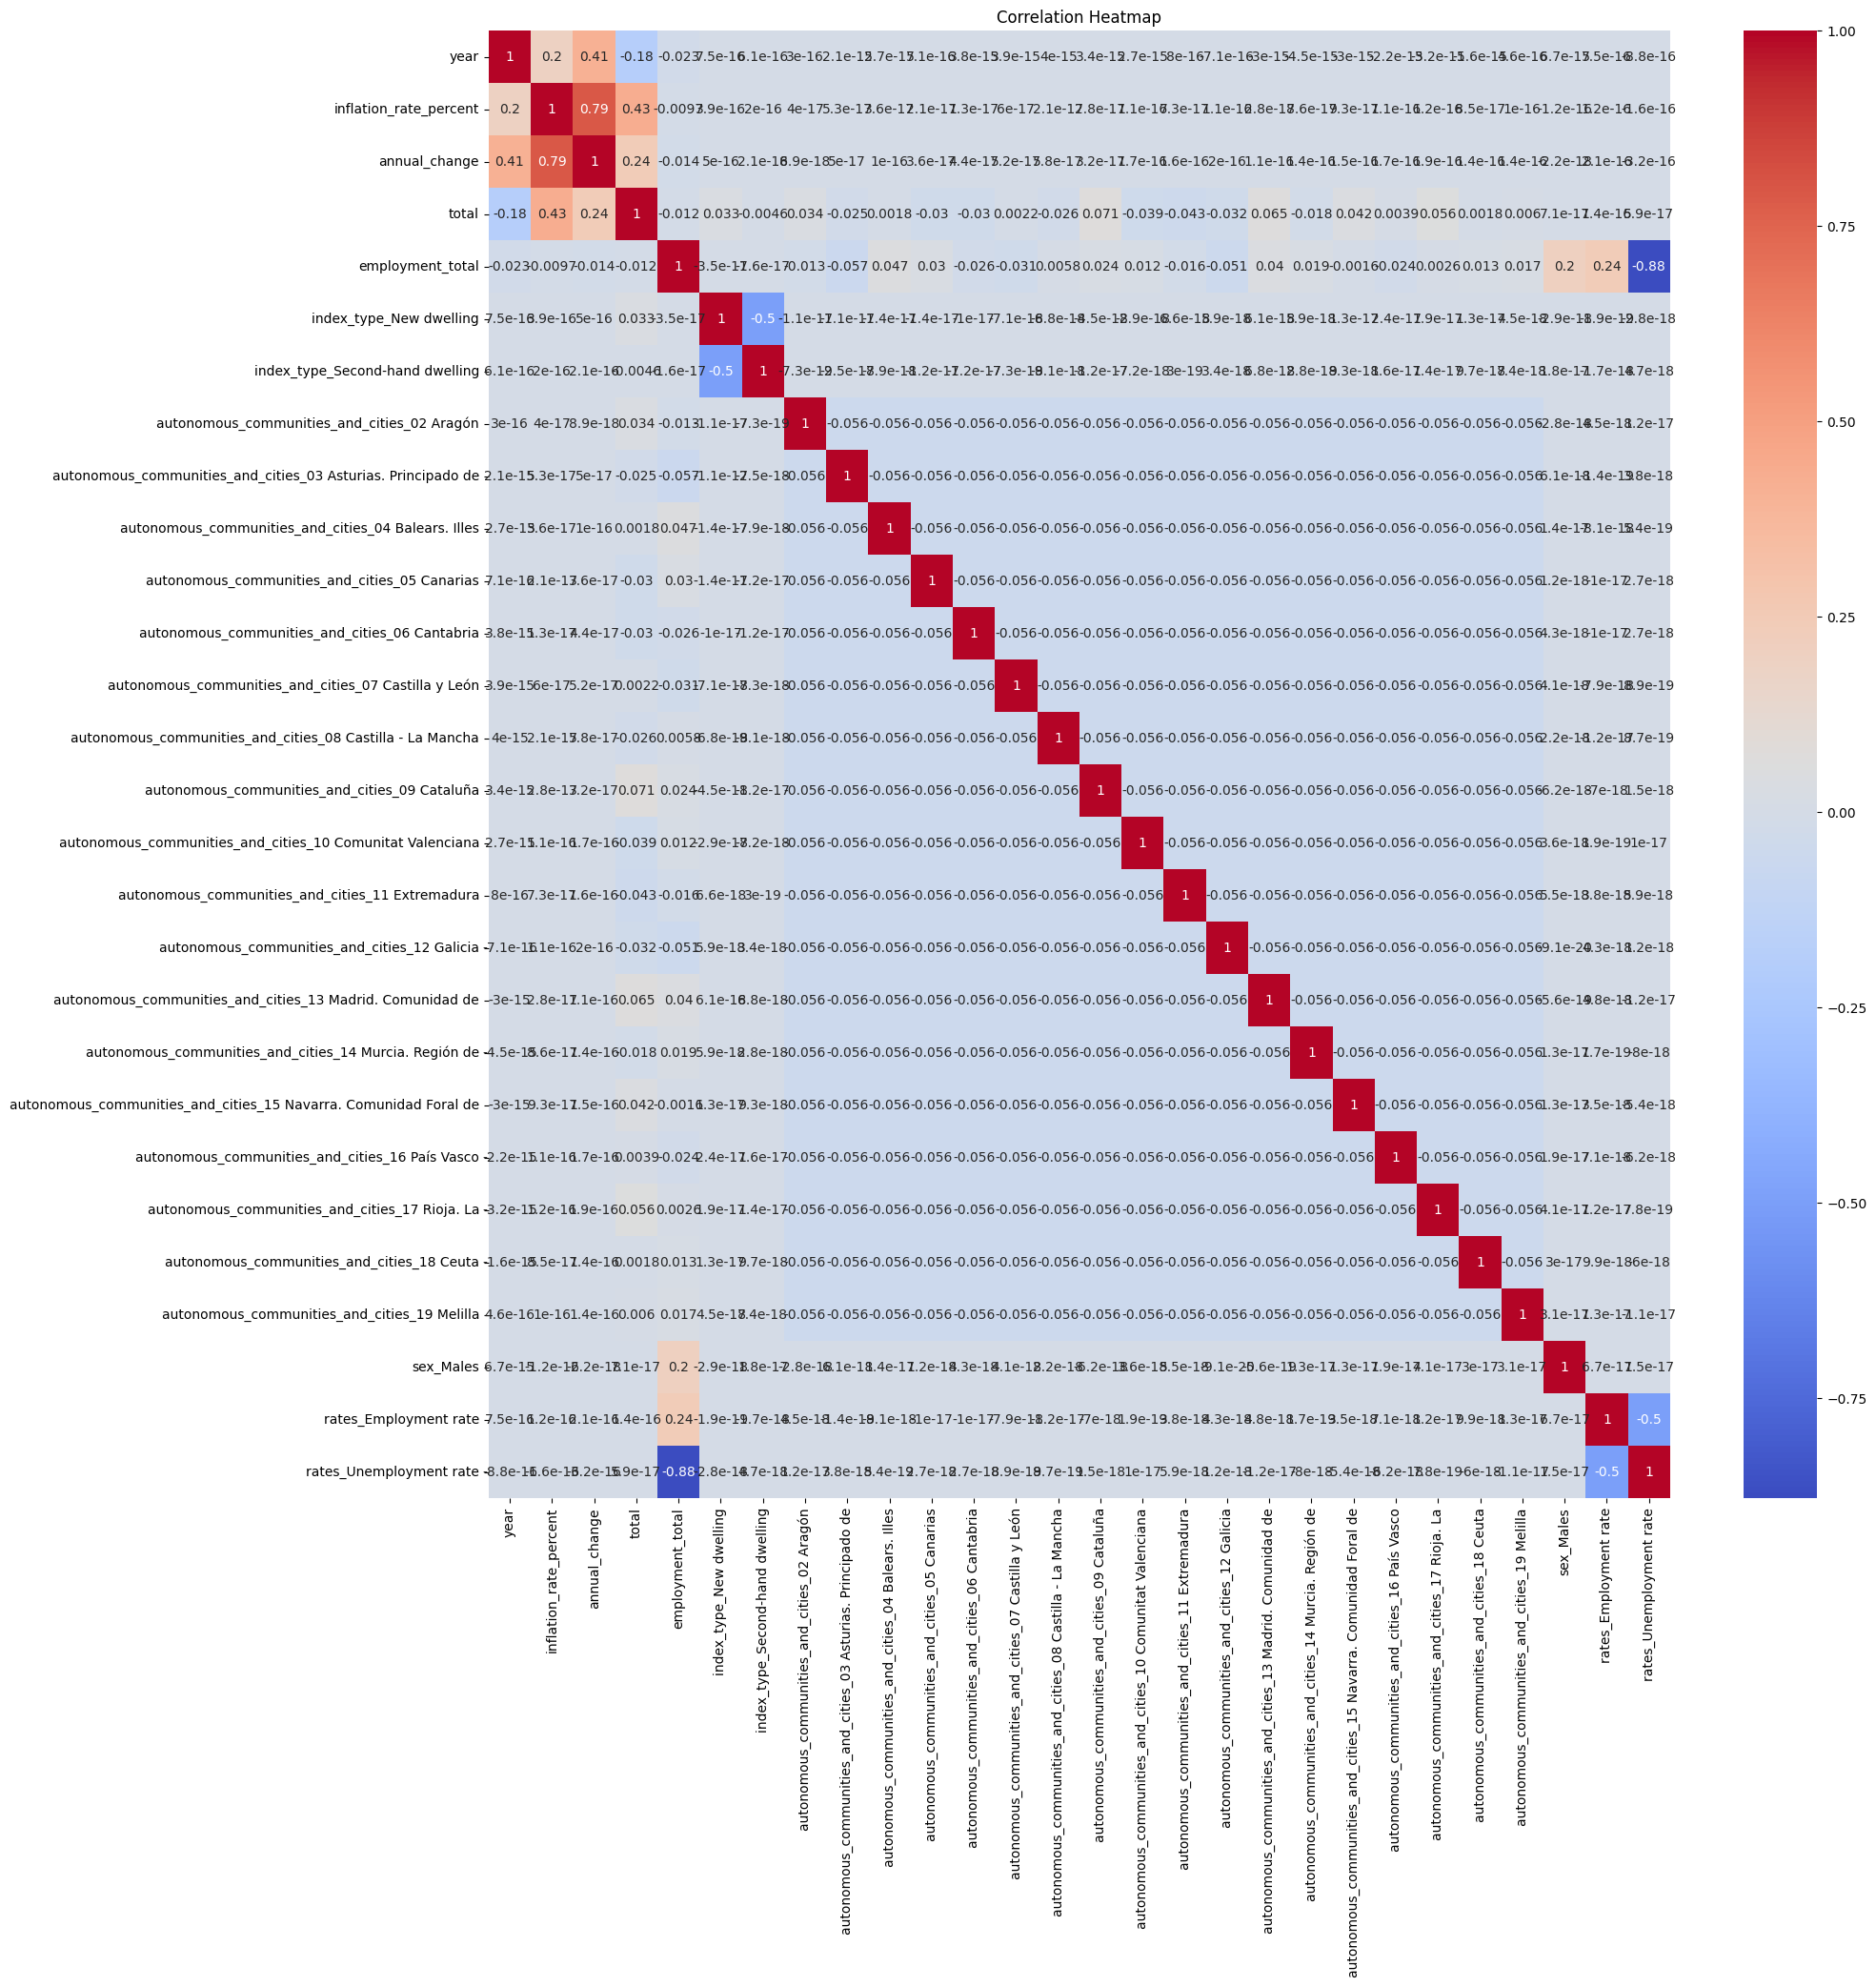

Mean Squared Error: 281.60636094576813
R^2 Score: 0.20390947397994785
Mean Average Error: 13.52632622643148


<ipython-input-28-f5d0d22976c8>:49: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals)


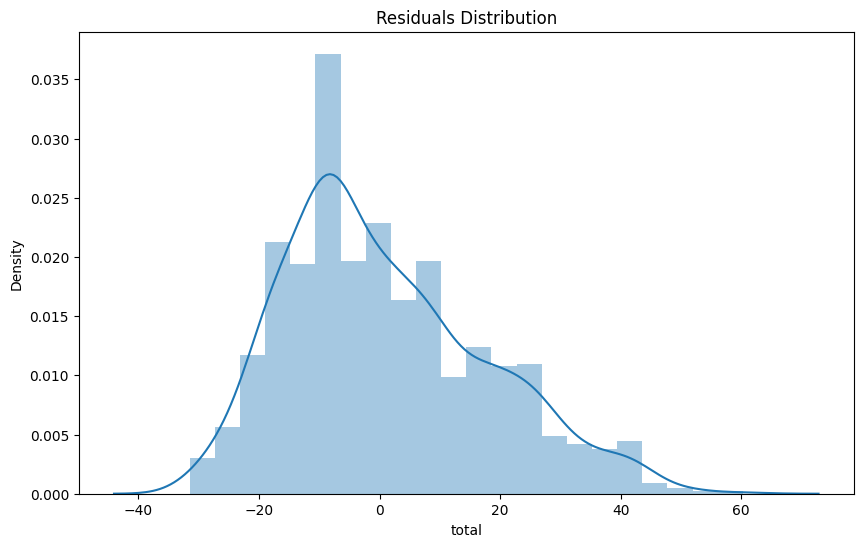

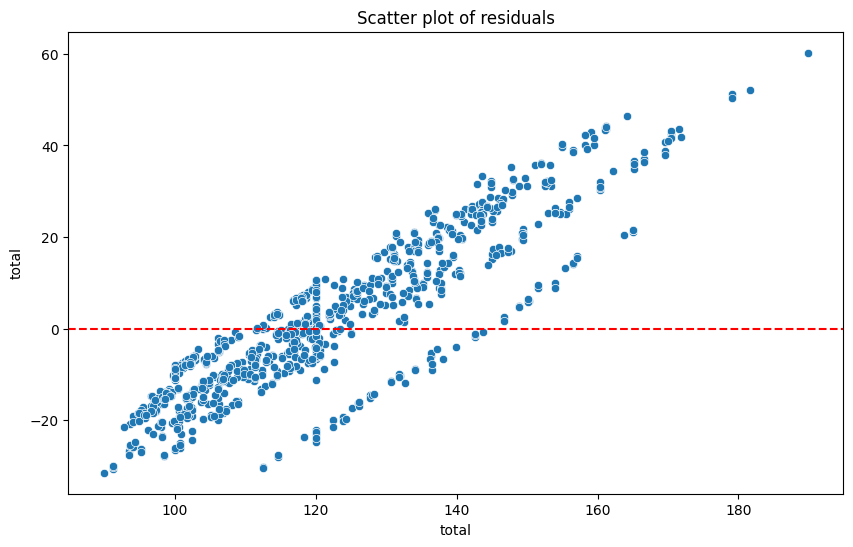

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Pre-processing
# Convert categorical columns to numerical
mean_value = df['total'].mean()
df['total'].fillna(mean_value, inplace=True)

df_joined_table_final = pd.get_dummies(df, columns=['index_type', 'autonomous_communities_and_cities', 'sex', 'rates'], drop_first=True)

# 2. Correlation Analysis
correlation_matrix = df_joined_table_final.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 3. Regression Analysis
# Target variable is 'total' (house price index)
# Features will include inflation and labor market variables
X = df_joined_table_final[['inflation_rate_percent', 'annual_change', 'employment_total'] + [col for col in df_joined_table_final if 'index_type_' in col or 'sex_' in col or 'rates_' in col]]
y = df_joined_table_final['total']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean Average Error: {mae}")

# 4. Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
sns.distplot(residuals)
plt.title("Residuals Distribution")
plt.show()

# Scatter plot of residuals
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Scatter plot of residuals")
plt.show()


From **Mean Squared Error: `281.60636094576813`** and **R^2 Score: `0.20390947397994785`** we can tell a linear regression model is not able to capture enough information for our dataset. We will try to implement more advanced model now.

## Random forest

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Average Error (MAE): {mae}")

# If you want to see feature importance
feature_importances = rf.feature_importances_
features = list(X.columns)
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")


Mean Squared Error (MSE): 78.28846019397973
R-squared (R2): 0.7786814855750799
Mean Average Error (MAE): 6.194696200661723
Feature: inflation_rate_percent, Importance: 0.26829259281358847
Feature: annual_change, Importance: 0.4579220184533809
Feature: employment_total, Importance: 0.204965150770701
Feature: index_type_New dwelling, Importance: 0.03279755554343864
Feature: index_type_Second-hand dwelling, Importance: 0.013246900061724846
Feature: sex_Males, Importance: 0.01085993232383291
Feature: rates_Employment rate, Importance: 0.009984910367746121
Feature: rates_Unemployment rate, Importance: 0.0019309396655871921




*   **R-squared (R2)**: approximately `0.7787`. This means that around `77.87%` of the variability in our target variable can be explained by the features in our model. This is a significant improvement compared to the linear regression model we tried earlier.


*   annual_change: This is the most important feature in your model, contributing to approximately `45.79%` of the prediction.
*   inflation_rate_percent: The second most important feature, accounting for about `26.83%`.
*   employment_total: The third most influential feature, with an importance of approximately `20.50%`.




## SVR

In [ ]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the Random Forest Regressor
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Average Error (MAE): {mae}")

Mean Squared Error (MSE): 311.2099576113587
R-squared (R2): 0.1202212264473076
Mean Average Error (MAE): 13.470399635059065


## XGB Regressor

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the Random Forest Regressor
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Make predictions
y_pred = xgb_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Average Error (MAE): {mae}")

# If you want to see feature importance
feature_importances = xgb_reg.feature_importances_
features = list(X.columns)
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Mean Squared Error (MSE): 58.611637045516474
R-squared (R2): 0.8343071200176213
Mean Average Error (MAE): 5.398890333762476
Feature: inflation_rate_percent, Importance: 0.1976245939731598
Feature: annual_change, Importance: 0.6157126426696777
Feature: employment_total, Importance: 0.03145294263958931
Feature: index_type_New dwelling, Importance: 0.04217081144452095
Feature: index_type_Second-hand dwelling, Importance: 0.022477565333247185
Feature: sex_Males, Importance: 0.027481241151690483
Feature: rates_Employment rate, Importance: 0.031390998512506485
Feature: rates_Unemployment rate, Importance: 0.03168924152851105


*   **R-squared (R2)**: approximately `0.8343`. This means that around `83.43%` of the variability in our target variable can be explained by the features in our model. This information combined with the lowest MSE score of `58.61` indicates that it is the best model so far.